In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [14]:
import yfinance as yf
data = yf.download('TSLA','2023-01-01','2023-09-01')

[*********************100%%**********************]  1 of 1 completed


In [15]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000


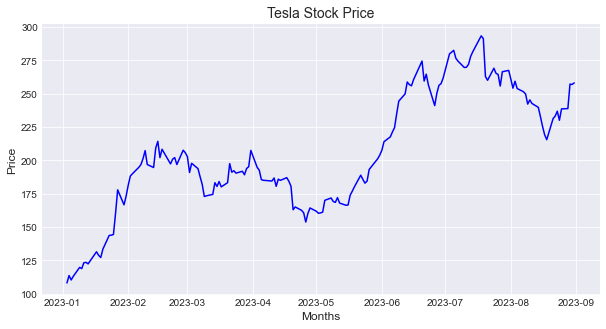

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], 'blue');
plt.style.use('seaborn-darkgrid')
plt.title("Tesla Stock Price", fontsize=14)
plt.xlabel("Months", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

In [39]:
# From the above graph it can be seen that the stock is trending upwards in 9 months from Jan to Sep - it is not stationary

result= adfuller(data['Close'])

result

(-1.8461967981357843,
 0.3577792440439749,
 0,
 166,
 {'1%': -3.4703698981001665,
  '5%': -2.8791138497902193,
  '10%': -2.576139407751488},
 1032.5883025861442)

In [38]:
p_value = result[1]
p_value

0.3577792440439749

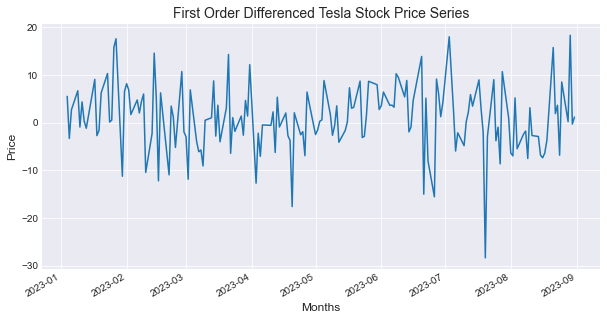

In [43]:
# As p-value of the adf test is greater than 0.05, the series is not stationary 

# Differencing
stationary_series = data['Close'].diff().dropna()

plt.figure(figsize=(10, 5))
stationary_series.plot()
plt.style.use('seaborn-darkgrid')
plt.title("First Order Differenced Tesla Stock Price Series", fontsize=14)
plt.xlabel("Months", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

In [54]:
# ADF test to check for stationarity

result= adfuller(stationary_series)

round(result[1],2)

0.0

<Figure size 1080x360 with 0 Axes>

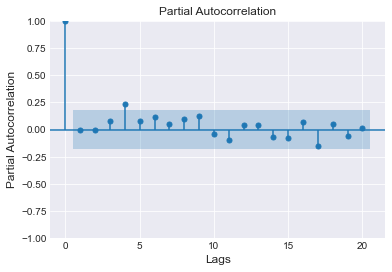

In [84]:
# As the p-value is 0 <0.05, the series is now stationary

train_data = int(len(data)*0.70)  # train data for training the model

plt.figure(figsize=(15,5))

plot_pacf(data['Close'][:train_data].diff().dropna(),lags=20)
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Partial Autocorrelation", fontsize=12)
plt.show()

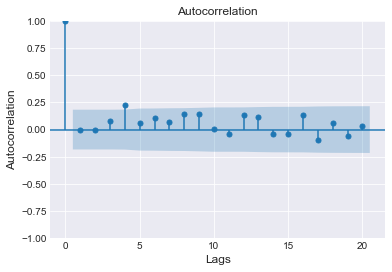

In [85]:
plot_acf(data['Close'][:train_data].diff().dropna(),lags=20)
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.show()

In [64]:
# Both PACF and ACF plot show statistically significant spike at lag 4 .

In [81]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
model = ARIMA(data['Close'][:train_data],order=(4,1,4))
model_fit = model.fit()

In [88]:
def predict_price(train_data):
    model = ARIMA(train_data,order=(4,1,4))
    model_fit = model.fit()
    forecast_results = model_fit.forecast()
    
    return forecast_results

In [89]:
data['predicted_price'] = data['Close'].rolling(train_data).apply(predict_price)

In [91]:
data['predicted_price'] = data['predicted_price'].shift(1)

In [93]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,predicted_price
Date,,,,,,,
2023-08-25,231.309998,239.000000,230.350006,238.589996,238.589996,106612200,228.765444
2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700,237.061342
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600,238.985591
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400,255.959411
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700,260.131853


In [94]:
def model_performance(observed,predicted):
    
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)
    
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)
    
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)
    
          
model_performance(data['Close'].iloc[train_data:],data['predicted_price'].iloc[train_data:])    

The Mean Absolute Error is 6.75
The Mean Squared Error is 81.15
The Root Mean Squared Error is 9.01
